In [74]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import math

In [75]:
# Taxi-v3 environment
taxi_env = gym.make('Taxi-v3')

# FrozenLake-v1 environment
frozen_env = gym.make('FrozenLake-v1', is_slippery=True)

### Implement the bounds

In [76]:
def hoeffding_bound(T, V_max, beta, gamma, n, N, delta):
    term1 = np.sqrt(gamma) / T
    term2 = np.sqrt((2 * np.log(2 * n * N / delta)) / T)
    bound = np.sqrt(2 * V_max) * beta * (term1 + term2)
    return bound

def bernstein_bound(T, V_max, beta, gamma, n, N, delta):
    term1 = np.sqrt(gamma) / T
    ln_term = (2/3) * np.log(n * N / delta)
    sqrt_term = np.sqrt(ln_term**2 + 8 * T * np.log(n * N / delta))
    term2 = (ln_term + sqrt_term) / (2 * T)
    bound = np.sqrt(2 * V_max) * beta * (term1 + term2)
    return bound

def bennett_bound(T, V_max, beta, gamma, n, N, delta):
    term1 = np.sqrt(gamma) / T
    term2 = np.sqrt((np.log(n * N / delta)) / T)
    bound = np.sqrt(2 * V_max) * beta * (term1 + term2)
    return bound

### Implement Parameters

In [77]:
# Define Parameters
# Taxi
gamma_taxi = 0.90  # Discount factor
R_max_taxi = 20    # 20 is the reward for suceeding everything else is negative 
V_max_taxi = R_max_taxi / (1 - gamma_taxi)
N = 51        # Number of atoms
z_min_taxi = -V_max_taxi
z_max_taxi = V_max_taxi
z_atoms_taxi = np.linspace(z_min_taxi, z_max_taxi, N)
delta_z_taxi = (z_max_taxi - z_min_taxi) / (N - 1)

# Frozen Lake
gamma_lake = 0.90  # Discount factor
R_max_lake = 1    # 1 is the reward for suceeding everything else is 0
V_max_lake = R_max_lake / (1 - gamma_lake)
N = 51        # Number of atoms
z_min_lake = -V_max_lake
z_max_lake = V_max_lake
z_atoms_lake = np.linspace(z_min_lake, z_max_lake, N)
delta_z_lake = (z_max_lake - z_min_lake) / (N - 1)

### Implement speedy Q-learning in categorical distributional Q-learning

In [78]:
def initialize_eta(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    eta = np.ones((n_states, n_actions, N)) / N  # Uniform distribution
    return eta

# For Taxi-v3
eta_taxi = initialize_eta(taxi_env)

# For FrozenLake-v1
eta_lake = initialize_eta(frozen_env)

In [79]:
# Projection Operator

def project_distribution(bellman_update, rewards, gamma, z_atoms, z_min, z_max, delta_z):
    # bellman_update: (N,) array of probabilities
    # rewards: scalar immediate reward
    # Compute the projection onto the support z_atoms
    Tz = np.clip(rewards + gamma * z_atoms, z_min, z_max)
    b = (Tz - z_min) / delta_z
    l = np.floor(b).astype(int)
    u = np.ceil(b).astype(int)
    
    m = np.zeros(N)
    for i in range(N):
        if l[i] == u[i]:
            m[l[i]] += bellman_update[i]
        else:
            m[l[i]] += bellman_update[i] * (u[i] - b[i])
            m[u[i]] += bellman_update[i] * (b[i] - l[i])
    # Normalize the distribution to sum to 1
    m /= m.sum() + 1e-8
    return m

# Epsilon greedy strategy

def epsilon_greedy_policy(eta, state, epsilon, z_atoms):
    if np.random.rand() < epsilon:
        return np.random.randint(eta.shape[1])  # Random action
    else:
        q_values = np.dot(eta[state], z_atoms)
        return np.argmax(q_values)
    
# Speedy Q-learning update

def speedy_q_learning_update(eta_k, eta_k_prev, state, action, reward, next_state, next_action, alpha_k, 
                             gamma, z_atoms, z_min, z_max, delta_z):
    # Compute the Bellman target distribution
    m = project_distribution(eta_k[next_state][next_action], reward, gamma, z_atoms, z_min, z_max, delta_z)
    
    # Speedy Q-learning update
    term1 = eta_k[state][action]
    term2 = alpha_k * (m - eta_k[state][action])
    term3 = (1 - alpha_k) * (m - eta_k_prev[state][action])
    eta_k_plus1 = term1 + term2 + term3
    
    # Normalize the distribution
    total = eta_k_plus1.sum()
    if total > 0:
        eta_k_plus1 /= total
    else:
        # If total is zero, set uniform distribution, avoid division by 0
        eta_k_plus1 = np.ones(N) / N
    
    return eta_k_plus1

In [92]:
# Train the agent

def train_speedy_q_learning(env, eta, num_episodes, R_max, bounds_params, gamma, z_atoms, z_min, z_max, delta_z):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    n = n_states * n_actions
    V_max = R_max / (1 - gamma)
    beta = 1 / (1 - np.sqrt(gamma))
    delta = bounds_params['delta']
    N = bounds_params['N']
    max_steps_per_episode = 1000
    
    eta_prev = eta.copy()
    bounds_data = {'hoeffding': [], 'bernstein': [], 'bennett': [], 'T': []}
    T = 0  # Total number of updates
    
    for episode in range(1, num_episodes + 1):
        state = env.reset()[0]
        done = False
        alpha_k = 1 / (episode + 1)
        epsilon = max(0.1, 1.0 - episode / num_episodes) #decreasing epsilon
        steps = 0

        while not done and steps < max_steps_per_episode:
            action = epsilon_greedy_policy(eta, state, epsilon, z_atoms)
            next_state, reward, done, _, _ = env.step(action)
            next_action = epsilon_greedy_policy(eta, next_state, epsilon, z_atoms)
            
            # Update eta
            eta_updated = speedy_q_learning_update(eta, eta_prev, state, action, reward, next_state, next_action, alpha_k,
                                                   gamma, z_atoms, z_min, z_max, delta_z)
            eta_prev[state][action] = eta[state][action]
            eta[state][action] = eta_updated
            
            state = next_state
            T += 1  # Increment total updates
            
            steps += 1
            
            # Compute bounds at intervals
            if T % bounds_params['interval'] == 0:
                h_bound = hoeffding_bound(T, V_max, beta, gamma, n, N, delta)
                b_bound = bernstein_bound(T, V_max, beta, gamma, n, N, delta)
                be_bound = bennett_bound(T, V_max, beta, gamma, n, N, delta)
                bounds_data['hoeffding'].append(h_bound)
                bounds_data['bernstein'].append(b_bound)
                bounds_data['bennett'].append(be_bound)
                bounds_data['T'].append(T)
    return eta, bounds_data

### Train the agent

In [93]:
bounds_params = {
    'delta': 0.05,
    'N': N,
    'interval': 100  # Compute bounds every 100 steps
}

num_episodes = 1000

# Train on Taxi-v3
eta_taxi, bounds_taxi = train_speedy_q_learning(taxi_env, eta_taxi, num_episodes, R_max_taxi, bounds_params, 
                                                gamma_taxi, z_atoms_taxi, z_min_taxi, z_max_taxi, delta_z_taxi)

num_episodes = 1000

# Train on FrozenLake-v1
eta_frozen, bounds_lake = train_speedy_q_learning(frozen_env, eta_lake, num_episodes, R_max_lake, bounds_params,
                                                    gamma_lake, z_atoms_lake, z_min_lake, z_max_lake, delta_z_lake)

### Plot

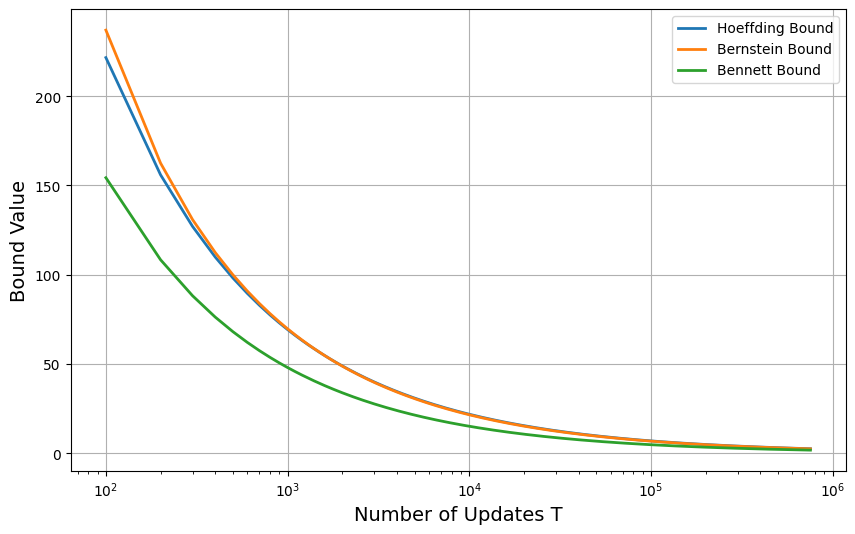

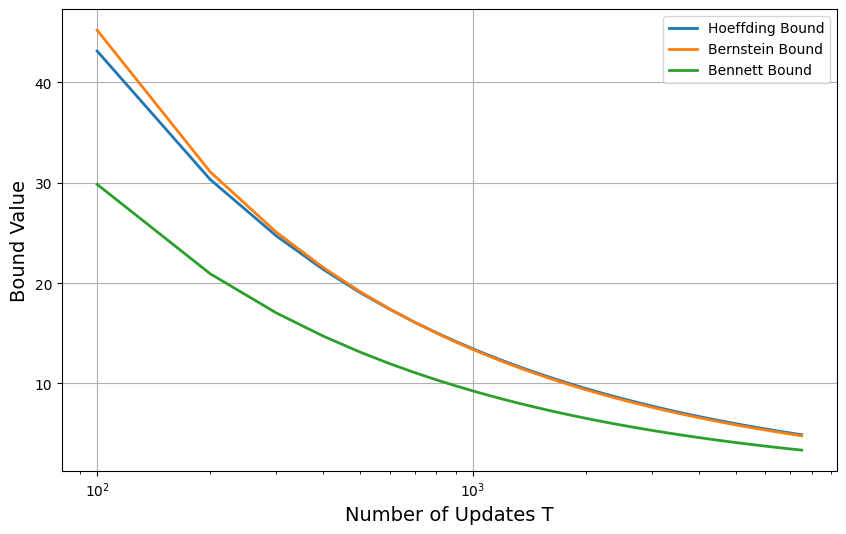

In [94]:
def plot_bounds(bounds_data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(bounds_data['T'], bounds_data['hoeffding'], label='Hoeffding Bound', linewidth=2)
    plt.plot(bounds_data['T'], bounds_data['bernstein'], label='Bernstein Bound', linewidth=2)
    plt.plot(bounds_data['T'], bounds_data['bennett'], label='Bennett Bound', linewidth=2)
    plt.xlabel('Number of Updates T', fontsize=14)
    plt.ylabel('Bound Value', fontsize=14)
    plt.xscale('log')
    plt.yscale('linear')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'Plots/{title}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot for Taxi-v3
plot_bounds(bounds_taxi, 'bounds_comparison_taxi')

# Plot for FrozenLake-v1
plot_bounds(bounds_lake, 'bounds_comparison_lake')

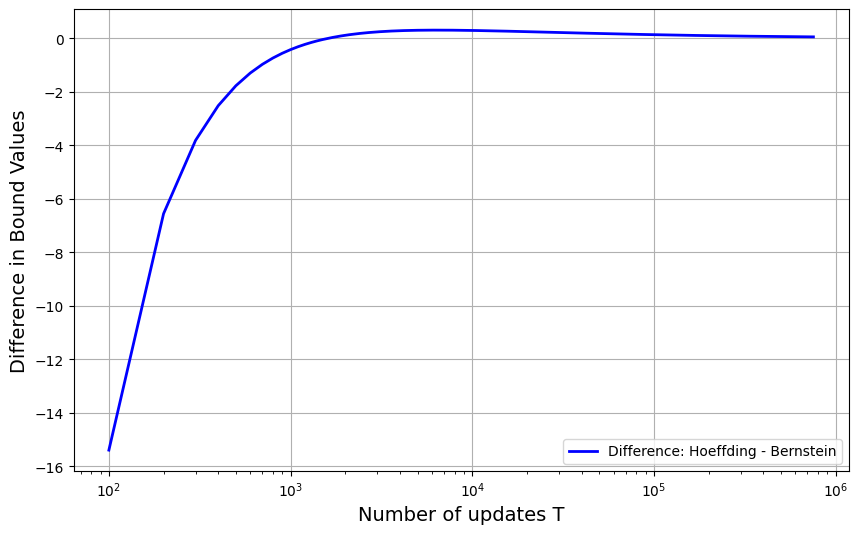

In [95]:
# Difference between Hoeffding and Bernstein for taxi
# Calculate the difference between Hoeffding and Bernstein bounds
difference = np.array(bounds_taxi["hoeffding"]) - np.array(bounds_taxi["bernstein"])
T_values = bounds_taxi['T']
# Plot the difference
plt.figure(figsize=(10, 6))

plt.plot(T_values, difference, label='Difference: Hoeffding - Bernstein', linestyle='-', linewidth=2, color='blue')

plt.xlabel('Number of updates T', fontsize=14)
plt.ylabel('Difference in Bound Values', fontsize=14)
plt.xscale('log')
plt.yscale('linear')
plt.grid(True)
plt.legend()

plt.savefig('Plots/difference_hoeffding_bernstein_experiment_taxi.png', dpi=300, bbox_inches='tight')
plt.show()

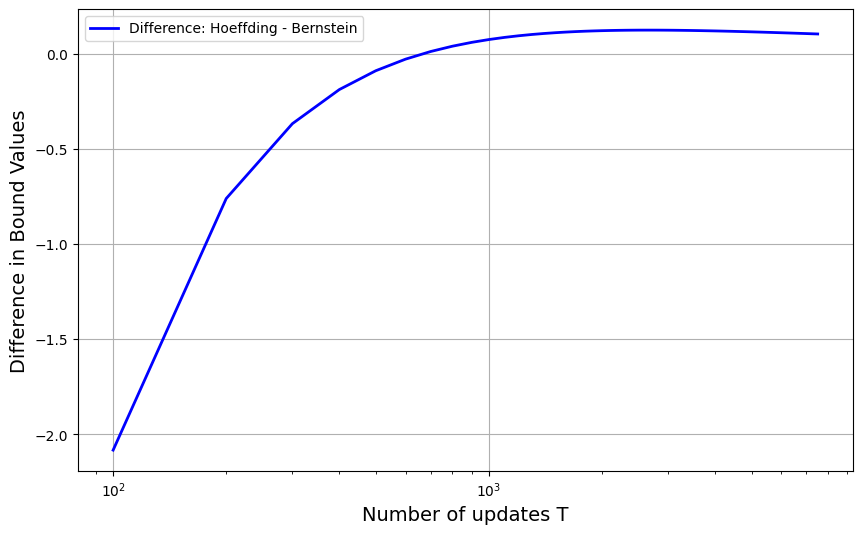

In [96]:
# Difference between Hoeffding and Bernstein for lake
# Calculate the difference between Hoeffding and Bernstein bounds
difference = np.array(bounds_lake["hoeffding"]) - np.array(bounds_lake["bernstein"])
T_values = bounds_lake['T']
# Plot the difference
plt.figure(figsize=(10, 6))

plt.plot(T_values, difference, label='Difference: Hoeffding - Bernstein', linestyle='-', linewidth=2, color='blue')

plt.xlabel('Number of updates T', fontsize=14)
plt.ylabel('Difference in Bound Values', fontsize=14)
plt.xscale('log')
plt.yscale('linear')
plt.grid(True)
plt.legend()

plt.savefig('Plots/difference_hoeffding_bernstein_experiment_lake.png', dpi=300, bbox_inches='tight')
plt.show()